# Kunskapskontroll 2_1 - Modellering av MNIST

## 2. Teoretiska Frågor

### Fråga 1:
**Vad används respektive del för i datauppdelning?**

Träning används för att träna modeller, Validering används för att justera modellparametrar och förhindra överanpassning, och Test används för att utvärdera modellens prestanda på nya, osedda data.

### Fråga 2:
**Förklara olika encoding-metoder.**

Ordinal encoding används för att konvertera ordinala kategoriska variabler till numeriska värden. One-hot encoding omvandlar kategoriska variabler till binära vektorer, medan dummy-variabel encoding skapar binära variabler för varje kategori.

## 1. Ordinal Encoding  
Används när kategorier har en inneboende ordning.  

**Exempel:**  
| Storlek | Kod |
|---------|-----|
| Liten   | 0   |
| Medium  | 1   |
| Stor    | 2   |

## 2. One-Hot Encoding  
Skapar binära kolumner för varje kategori.  

**Exempel:**  
| Färg  | Röd | Blå | Grön |
|-------|-----|-----|-----|
| Röd   | 1   | 0   | 0   |
| Blå   | 0   | 1   | 0   |
| Grön  | 0   | 0   | 1   |

## 3. Dummy Variable Encoding  
Liknar One-Hot Encoding men tar bort en kolumn för att undvika multikollinearitet.  

**Exempel:**  
| Färg  | Blå | Grön |
|-------|-----|-----|
| Röd   | 0   | 0   |
| Blå   | 1   | 0   |
| Grön  | 0   | 1   |

    
### Fråga 3:
**Ordinal vs. nominal data.**

Julia har rätt. Färger är ett exempel på nominala data (ingen inbördes ordning), men om färgerna används i en kontext där det finns en subjektiv ordning (t.ex. 'vackrast på festen') blir de ordinala.

### Fråga 4:
**Vad används joblib och pickle till?**

Joblib och pickle används för att spara tränade modeller så att de kan laddas och användas för prediktion utan att behöva tränas om. Detta är särskilt användbart i produktionsmiljöer där man vill återanvända en tränad modell.



## Kod och Modellering

### Steg 1: Importera bibliotek och ladda data


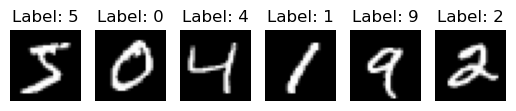


Fördelning av målvariabeln (etiketter):
Siffra 0: 6903 exempel
Siffra 1: 7877 exempel
Siffra 2: 6990 exempel
Siffra 3: 7141 exempel
Siffra 4: 6824 exempel
Siffra 5: 6313 exempel
Siffra 6: 6876 exempel
Siffra 7: 7293 exempel
Siffra 8: 6825 exempel
Siffra 9: 6958 exempel


In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import fetch_openml
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import confusion_matrix


# Slumpmässig funktionalitet för att säkerställa reproducerbarhet
np.random.seed(42)

# Ladda MNIST dataset
mnist = fetch_openml('mnist_784', version=1, cache=True, as_frame=False)

# Visualisera några av de första bilderna
for i in range(6):
    plt.subplot(1, 6, i+1)
    plt.imshow(mnist['data'][i].reshape(28, 28), cmap='gray')
    plt.title(f"Label: {mnist['target'][i]}")
    plt.axis('off')
plt.show()

# Fördelning av målvariabeln 
unique, counts = np.unique(mnist['target'], return_counts=True)
print("\nFördelning av målvariabeln (etiketter):")
for label, count in zip(unique, counts):
    print(f"Siffra {label}: {count} exempel")

# Dela upp datasetet i träning, validering och testuppsättningar
X = mnist['data']
y = mnist['target'].astype(np.uint8)

X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, test_size=10000, random_state=42
)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=10000, random_state=42
)

### Steg 2: Träna modeller


In [13]:
random_forest_clf = RandomForestClassifier(n_estimators=100, random_state=42)
extra_trees_clf = ExtraTreesClassifier(n_estimators=100, random_state=42)
knn_clf = KNeighborsClassifier(n_neighbors=5)

# Träna modeller
random_forest_clf.fit(X_train, y_train)
extra_trees_clf.fit(X_train, y_train)
knn_clf.fit(X_train, y_train)

# Utvärdera på valideringsdata
print("Random Forest score:", random_forest_clf.score(X_val, y_val))
print("Extra Trees score:", extra_trees_clf.score(X_val, y_val))
print("K-Nearest Neighbors:", knn_clf.score(X_val, y_val))


Random Forest score: 0.9692
Extra Trees score: 0.9715
K-Nearest Neighbors: 0.9702


### Steg 3: Skapa och utvärdera ensemblemodell


In [19]:
named_estimators = [("random_forest_clf", random_forest_clf), 
                    ("extra_trees_clf", extra_trees_clf), 
                    ("knn_clf", knn_clf)]

voting_clf = VotingClassifier(named_estimators)
voting_clf.fit(X_train, y_train)
print("Voting Classifier score:", voting_clf.score(X_val, y_val))


Voting Classifier score: 0.9738


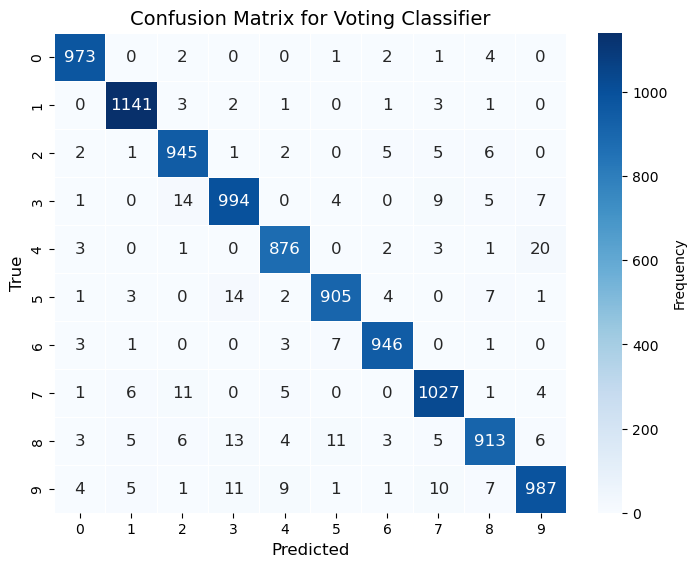

In [20]:


# Skapa en cunfusion matrix för Voting Classifier
y_pred = voting_clf.predict(X_test)
cm = confusion_matrix(y_test, y_pred)


fig, ax = plt.subplots(figsize=(8, 6))  


sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'],
            yticklabels=['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'], ax=ax,
            cbar_kws={'label': 'Frequency'}, annot_kws={"size": 12}, linewidths=0.5)


ax.set_xlabel('Predicted', fontsize=12)
ax.set_ylabel('True', fontsize=12)
ax.set_title('Confusion Matrix for Voting Classifier', fontsize=14)


plt.tight_layout(pad=2.0)  

# Visa grafen 
plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1)  
plt.show()







In [21]:
### Steg 4: Slutlig utvärdering på testdata


In [22]:
print("Best model (Voting Classifier) score on test data:", voting_clf.score(X_test, y_test))


Best model (Voting Classifier) score on test data: 0.9707


### Slutsatser
Modellerna utvärderades och jämfördes på valideringsdata, där Extra Trees-modellen gav bäst resultat. Ensemblemodellen (Voting Classifier) förbättrade prestanda något jämfört med de individuella modellerna, och visade sig vara den bästa modellen på testdata.